# Visual-Area Autolabeler: Training

## About

[Noah C. Benson](nben@uw.edu)$^{1,2,3}$, [Shaoling Chen](sc6995@nyu.edu)$^{4}$, and [Jonathan Winawer](jonathan.winawer@nyu.edu)$^{1,2}$

$^1$Department of Psychology  
$^2$Center for Neural Sciences  
$^4$Courant Institute for Mathematics  
New York University  
New York, NY 10012

$^3$*Current Affiliation:*  
eScience Institute  
University of Washington  
Seattle, WA 98122

## Initialization

### Configuration

In [1]:
hcp_lines_path = None

genetic_data_path = None

behavioral_data_path = None

log_level = 'INFO'

valset_size = 32

image_size = 128

cache_path  = '/home/nben/tmp/hcp_resnet_cache'
resnet_path = '/home/nben/tmp/hcp_resnet_cache/resnet_training'

### Libraries

In [2]:
import os, sys, six, time, copy, pimms, pandas, PIL, cv2
import numpy as np
import scipy as sp
import nibabel as nib
import neuropythy as ny
import torch, torchvision, torchsummary

import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv

In [3]:
%matplotlib inline

In [4]:
# #TODO Later this will be removed when hcp-lines is integrated with
# neuropythy's datasets
hcppath = '/home/nben/code/hcp-lines'
if hcppath not in sys.path:
    sys.path.append(hcppath)
import hcp_lines

### Utilities

In [5]:
def constantly(x):
    '''
    constantly(x) yields a function f such that f(...) yields x, no matter what
    arguments are passed to f.
    '''
    def _lambda(*args, **kw):
        return x
    return _lambda

In [6]:
def plot_prediction(dataset, k, model, axes=None, figsize=(6,1), dpi=72*4,
                    min_alpha=0.5):
    '''
    Plots the data, true label, and predicted label (by model) of dataset[k].
    '''
    (imdat, imlbl) = dataset[k]
    impre = torch.sigmoid(model(imdat[None,:,:,:].float()))
    impre = dataset.inv_transform(None, impre.detach()[0])
    (imdat, imlbl) = dataset.inv_transform(imdat, imlbl)
    if axes is None:
        (fig,axes) = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    # with imdat we want to adjust the alpha layer
    imdat = np.array(imdat)
    imdat[:,:,3] = imdat[:,:,3]*(1 - min_alpha) + min_alpha
    for (ax,im) in zip(axes, [imdat, imlbl, impre]):
        ax.imshow(np.clip(im, 0, 1))
        ax.axis('off')
    return axes

## Setup Data

### The HCP-Lines Dataset

In [7]:
data = ny.data['hcp_lines']

Split into training and validation datasets

In [8]:
# Filter out error subjects
sids = [sid for sid in data.subject_list
        if ('mean',sid,'lh') not in data.exclusions
        if ('mean',sid,'rh') not in data.exclusions]
sids = np.array(sids)
val_sids = np.random.choice(sids, valset_size)
trn_sids = np.setdiff1d(sids, val_sids)

### The PyTorch Dataset Class

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

default_image_size = 512

class HCPAnatomyDataset(torch.utils.data.Dataset):
    """
    HCPAnatomyDataset is a PyTorch dataset for the HCP. It produces 3xNx2N
    images of a subject's occipital poles (LH and RH) in which the three
    channels correspond to:
     (0) curvature (-1:1 is rescaled to 0:1)
     (1) sulcal depth (-2:2 is rescaled to 0:1)
     (3) cortical thickness (1:6 is rescaled to 0:1)    
    """
    def __init__(self, sids, image_size=default_image_size, cache_path=None,
                 downsample=2, use_func=False):
        """
        """
        self.sids = sids
        self.image_size = image_size
        self.cache_path = cache_path
        self.downsample = downsample
        self.use_func = use_func
        self._cache = {}
    def fwd_transform(self, inimg, outimg=None):
        """
        Applies pre-model-training transformations to the input and output
        images and yields the resulting images. If one of the images is
        passed as None, then only the other image is transformed and yielded.
        """
        if inimg is None and outimg is None: return None
        # The output image only needs to be to-tensor'ed
        if outimg is not None:
            tmp = np.asarray(outimg)
            hcols = tmp.shape[1] // 2
            outimg = np.zeros(tmp.shape[:2] + (6,), dtype=tmp.dtype)
            outimg[:,:hcols,:3] = tmp[:,:hcols]
            outimg[:,hcols:,3:] = tmp[:,hcols:]
            outimg = transforms.functional.to_tensor(outimg)
        # The input image needs to be normalized and to-tensor'ed
        if inimg is not None:
            #inimg = np.clip((inimg - 127.5) / 127.5, -1, 1)
            inimg = transforms.functional.to_tensor(inimg)
        return (outimg if inimg  is None else
                inimg  if outimg is None else (inimg, outimg))
    def inv_transform(self, inimg, outimg=None):
        """
        Applies pre-model-training inverse transformations to the input and
        output images, either of which may be None (see also fwd_transform).
        """
        if inimg is None and outimg is None: return None
        if outimg is not None:
            outimg = np.transpose(outimg.numpy(), (1,2,0))
            outimg = outimg[:,:,:3] + outimg[:,:,3:]
        if inimg is not None:
            #inimg = [np.clip(sl, -1, 1) * 127.5 + 127.5 for sl in inimg.numpy()]
            inimg = [np.clip(sl, 0, 1) for sl in inimg.numpy()]
            inimg = np.transpose(inimg, (1,2,0)).astype('float')
        return (outimg if inimg  is None else
                inimg  if outimg is None else (inimg, outimg))
    def __len__(self):
        return len(self.sids)
    def __getitem__(self, k):
        from skimage.transform import pyramid_reduce
        (p,f,s) = HCPAnatomyDataset.images(self.sids[k],
                                           image_size=self.image_size, 
                                           cache=self._cache,
                                           cache_path=self.cache_path)
        p = f if self.use_func else p
        return self.fwd_transform(p, s)
    def get(self, k):
        return HCPAnatomyDataset.images(self.sids[k],
                                        image_size=self.image_size, 
                                        cache=self._cache,
                                        cache_path=self.cache_path)
    @staticmethod
    def resize_image(im, image_size):
        """
        Yields the image resized to have the same number of rows as image_size.
        """
        from skimage.transform import pyramid_expand, pyramid_reduce
        im = np.asarray(im)
        imsz = im.shape[0]
        if imsz < image_size:
            im = pyramid_expand(im, image_size/imsz, multichannel=True)
        elif imsz > image_size:
            im = pyramid_reduce(im, imsz/image_size, multichannel=True)
        return im
    @staticmethod
    def images(sid, cache={}, image_size=default_image_size, cache_path=None):
        """
        Yields the (param, solution) images for the given subject-ID. If available,
        these images are loaded from cache or from the cache_path.
        """
        im = cache.get(sid, None)
        if im is not None: return im
        found = False
        if cache_path is not None:
            iflnm = os.path.join(cache_path, 'images', '%s_anat.png' % sid)
            fflnm = os.path.join(cache_path, 'images', '%s_func.png' % sid)
            oflnm = os.path.join(cache_path, 'images', '%s_v123.png' % sid)
            try:
                with PIL.Image.open(iflnm) as f: im = np.array(f)
                param = im
                with PIL.Image.open(fflnm) as f: im = np.array(f)
                fparam = im
                with PIL.Image.open(oflnm) as f: im = np.array(f)
                sol = im
                cache[sid] = (param, fparam, sol)
                found = True
            except Exception: pass
        # generate the images then...
        #if found and sol.shape[0] != default_image_size:
        #    found = False
        if not found:
            (param,fparam,sol) = HCPAnatomyDataset.generate_images(sid)
        (param,fparam,sol) = [HCPAnatomyDataset.resize_image(im, image_size)
                              for im in (param, fparam, sol)]
        # Put them in the cache and save them if possible
        cache[sid] = (param, fparam, sol)
        if cache_path is not None and not found:
            flnm = os.path.join(cache_path, 'images', '%s_anat.png' % sid)
            im = np.clip(param, 0, 255).astype('uint8')
            PIL.Image.fromarray(im).save(flnm)
            flnm = os.path.join(cache_path, 'images', '%s_func.png' % sid)
            im = np.clip(fparam, 0, 255).astype('uint8')
            PIL.Image.fromarray(im).save(flnm)
            flnm = os.path.join(cache_path, 'images', '%s_v123.png' % sid)
            im = np.clip(sol, 0, 255).astype('uint8')
            PIL.Image.fromarray(im).save(flnm)
        return (param, fparam, sol)
    anat_layers = {'curvature': (-1,1), 'convexity':(-2,2),
                   'thickness':(1,6),   'surface_area':(0,3)}
    func_layers = {'prf_polar_angle': (-180,180),
                   'prf_eccentricity':(0,12),
                   'prf_radius':(0,4),
                   'prf_variance_explained': (0,1)}
    @staticmethod
    def generate_images(sid, image_size=default_image_size,
                        anat_layers=Ellipsis, func_layers=Ellipsis):
        """
        Given a subject-id, generates and yields the tuple (param_image, sol_iamge)
        where param_image is the input image for the neural net and the sol_image
        is the output / solution to which the net should be trained.
        """
        dis = default_image_size
        if anat_layers is Ellipsis: anat_layers = HCPAnatomyDataset.anat_layers
        if func_layers is Ellipsis: func_layers = HCPAnatomyDataset.func_layers
        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
        # Get the subject and make a figure.
        sub = ny.data['hcp_lines'].subjects[sid]
        ms  = {h:ny.to_flatmap('occipital_pole', sub[h]) for h in ['lh','rh']}
        ims = []
        for (p,(mn,mx)) in six.iteritems(anat_layers):
            (fig,axs) = plt.subplots(1,2, figsize=(2,1), dpi=dis)
            fig.subplots_adjust(0,0,1,1,0,0)
            fig.set_facecolor('k')
            for (h,ax) in zip(['lh','rh'], axs):
                ax.axis('off')
                ax.set_facecolor('k')
                ny.cortex_plot(ms[h], color=p, axes=ax,
                               cmap='gray', vmin=mn, vmax=mx)
            canvas = FigureCanvas(fig)
            canvas.draw()
            bufstr = canvas.tostring_rgb()
            plt.close(fig)
            image = np.frombuffer(bufstr, dtype='uint8')
            image = np.reshape(image, (dis, dis*2, 3))
            ims.append(image[:,:,0])
        param = np.transpose(ims, (1,2,0))
        # Repeat for the functional param image
        ims = []
        for (p,(mn,mx)) in six.iteritems(func_layers):
            (fig,axs) = plt.subplots(1,2, figsize=(2,1), dpi=dis)
            fig.subplots_adjust(0,0,1,1,0,0)
            fig.set_facecolor('k')
            for (h,ax) in zip(['lh','rh'], axs):
                ax.axis('off')
                ax.set_facecolor('k')
                # There is one special case: polar angle; we want to give the
                # rh and lh a similar map that is as non-circular as possible.
                if p.endswith('polar_angle'):
                    pp = ms[h].prop(p)
                    pp = -pp if h == 'rh' else pp
                    pp = np.mod(90 - pp + 180, 360) - 180
                else: pp = p
                ny.cortex_plot(ms[h], color=pp, axes=ax,
                               cmap='gray', vmin=mn, vmax=mx)
            canvas = FigureCanvas(fig)
            canvas.draw()
            bufstr = canvas.tostring_rgb()
            plt.close(fig)
            image = np.frombuffer(bufstr, dtype='uint8')
            image = np.reshape(image, (dis, dis*2, 3))
            ims.append(image[:,:,0])
        fparam = np.transpose(ims, (1,2,0))
        # Repeat for the solution image
        ims = []
        for lbl in [1,2,3]:
            (fig,axs) = plt.subplots(1,2, figsize=(2,1), dpi=dis)
            fig.subplots_adjust(0,0,1,1,0,0)
            fig.set_facecolor('k')
            for (h,ax) in zip(['lh','rh'], axs):
                ax.axis('off')
                ax.set_facecolor('k')
                ny.cortex_plot(ms[h], color=(ms[h].prop('visual_area') == lbl),
                               axes=ax, cmap='gray', vmin=0, vmax=1)
            canvas = FigureCanvas(fig)
            canvas.draw()
            bufstr = canvas.tostring_rgb()
            plt.close(fig)
            image = np.frombuffer(bufstr, dtype='uint8')
            image = np.reshape(image, (dis, dis*2, 3))
            ims.append(image[:,:,0])
        sol = np.transpose(ims, (1,2,0))
        return (param, fparam, sol)

To force the saving of all images, use this code block.

```python
def _force_sid(k):
    if k > len(sids): return False
    cache_path = '/home/nben/tmp/hcp_resnet_cache'
    dset = HCPAnatomyDataset(sids, cache_path=cache_path)
    im = dset.get(k)
    return True

import multiprocessing as mp
chunksz = 16
for k in range((len(sids) + chunksz - 1) // chunksz):
    with mp.Pool(chunksz) as pool:
        pool.map(_force_sid, range(chunksz*k, chunksz*(k+1)))
```

This cell creattes a few dictionary objects containing anatomical and/or functional data for both the training and validation sets.

In [10]:
trn_sets = pimms.lmap(
    {'anat':lambda:HCPAnatomyDataset(trn_sids, cache_path=cache_path,
                                     use_func=False, image_size=image_size),
     'func':lambda:HCPAnatomyDataset(trn_sids, cache_path=cache_path,
                                     use_func=True, image_size=image_size)})
val_sets = pimms.lmap(
    {'anat':lambda:HCPAnatomyDataset(val_sids, cache_path=cache_path,
                                     use_func=False, image_size=image_size),
     'func':lambda:HCPAnatomyDataset(val_sids, cache_path=cache_path,
                                     use_func=True, image_size=image_size)})
datasets = pimms.persist({'trn': trn_sets, 'val': val_sets})

In [11]:
(fnc,lbl) = datasets['val']['func'][0]
(fnc,lbl) = datasets['val']['func'].inv_transform(fnc, lbl)

In [12]:
def make_dataloaders(dataset='func', shuffle=True, batch_size=2, **kw):
    '''
    make_dataloaders() yields training and validation dataloaders (in a
      dictionary whose keys are 'trn' and 'val'). The optional arguments
      `use_func` and `batch_size` may be given, and any other keyword
      arguments are ignored.
    '''
    return {
        k: DataLoader(sets[dataset], batch_size=batch_size, shuffle=shuffle)
        for (k,sets) in datasets.items()}

## Construct Model

In [13]:
def convrelu(in_channels, out_channels, kernel, padding):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        torch.nn.ReLU(inplace=True))
class ResNetUNet(torch.nn.Module):
    def __init__(self, n_chan, n_class, pretrained_resnet=True):
        """
        ResNetUNet(input_channels, output_classes) yields an untrained PyTorch
        neural-network Module appropriate for training the V123 classification.
        """
        import torch.nn as nn
        super().__init__()
        
        self.pretrained_resnet = pretrained_resnet
        self.base_model = models.resnet18(pretrained=pretrained_resnet)
        if n_chan != 3:
            # adjust the first convolution's number of channels:
            c1 = self.base_model.conv1
            self.base_model.conv1 = nn.Conv2d(
                n_chan, c1.out_channels,
                kernel_size=c1.kernel_size, stride=c1.stride,
                padding=c1.padding, bias=c1.bias)

        self.base_layers = list(self.base_model.children())
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(n_chan, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)
        
        return out

def resnet_model(pretrained=True, nclass=6, nchann=4, **kw):
    '''
    resnet_model() yields a ResNetUNet model object with 3 output classes and
      4 input channels. The `nclass` and `nchann` keywords can be used to
      alter the model, as well as the `pretrained` option. Keyword arguments
      not understood by the ResNetUNet class are ignored.
    '''
    return ResNetUNet(nchann, nclass, pretrained_resnet=pretrained)

## Model Training

In [14]:
def calc_loss(pred, target, metrics=None,
              bce_weight=0.5, smooth=0.5, save_path=None):
    '''
    calc_loss(pred, target) calculates the loss value between the given
      prediction and target/labels.
    '''
    import loss
    # Apply sigmoid and dice loss
    bce = torch.nn.functional.binary_cross_entropy_with_logits(pred, target)
    dice = loss.dice_loss(torch.sigmoid(pred), target, smooth=smooth)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    if metrics is not None:
        metrics['bce']  += bce.data.cpu().numpy() * target.size(0)
        metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
        metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss
log_header_format = "%-5s  %-7s  %-5s   %-8s  %-8s  %-8s   %-8s  %-8s  %-8s"
log_format = "%2d/%2d  %7.5f  %5.1f | %8.3f  %8.3f  %8.3f | %8.3f  %8.3f  %8.3f %s"
log_header = log_header_format % (
    "epoch", "  lr   ", "dt[s]",
    "trn bce ", "trn dice", "trn loss",
    "val bce ", "val dice", "val loss")
log_header_hline = log_header_format % (
    "="*5, "="*7, "="*5, "="*8, "="*8, "="*8, "="*8, "="*8, "="*8)
log_header_hline = log_header_hline.replace(' ', '-')
log_header_hline = "%s+%s+%s" % (
    log_header_hline[:22], log_header_hline[23:53], log_header_hline[54:])
def log_epoch(metrics, epochno=None, epochmax=None, lr=None, dt=None,
              logger=print, endl=""):
    '''
    log_epoch(metrics, epochno, lr, dt) logs an epoch's metrics.
    If metrics is None, then a header is printed. If metrics is Ellipsis, then
    a separator line is printed.
    '''
    if logger is None: return
    if metrics is None:
        logger(log_header)
        logger(log_header_hline)
    elif metrics is Ellipsis:
        logger('-' * len(log_header))
    else:
        t = metrics['trn']
        v = metrics['val']
        tup = ((epochno+1, epochmax, lr, dt) +
               tuple([t[q] for q in ['bce','dice','loss']]) +
               tuple([v[q] for q in ['bce','dice','loss']]) +
               (endl,))
        logger(log_format % tup)
def train_model(model, optimizer, scheduler, dataloaders, smooth=1.0,
                num_epochs=25, save_path=None, logger=print, bce_weight=0.5,
                device=None, hlines=False):
    '''
    train_model(model, optimizer, scheduler, dataloaders) runs training on the
      given model and returns the newly trained model. This represents a single
      set of epochs with a single StepLR decay.
    '''
    from collections import defaultdict
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    best_dice = 1e10
    log_epoch(None, logger=logger)
    for epoch in range(num_epochs):
        since = time.time()
        allmetrics = {}
        savestr = ""
        lr0 = optimizer.param_groups[0]['lr']
        # Each epoch has a training and validation phase
        for phase in ['trn', 'val']:
            if phase == 'trn':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            metrics = defaultdict(float)
            epoch_samples = 0
            for (inputs, labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'trn'):
                    outputs = model(inputs.float())
                    loss = calc_loss(outputs, labels, metrics,
                                     bce_weight=bce_weight, smooth=smooth)
                    # backward + optimize only if in training phase
                    if phase == 'trn':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                # statistics
                epoch_samples += inputs.size(0)
            for k in metrics.keys():
                metrics[k] /= epoch_samples
            epoch_loss = metrics['loss']
            # deep copy the model
            if phase == 'val':
                if epoch_loss < best_loss:
                    savestr = "*"
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if metrics['dice'] < best_dice:
                    best_dice = metrics['dice']
            allmetrics[phase] = metrics
        time_elapsed = time.time() - since
        log_epoch(allmetrics, epoch, num_epochs, lr0, time_elapsed,
                  endl=savestr, logger=logger)
        if hlines: log_epoch(Ellipsis, logger=logger)
        if save_path is not None:
            torch.save(model.state_dict(), 
                       os.path.join(save_path, "model%06d.pkl" % epoch))
            torch.save(optimizer.state_dict(), 
                       os.path.join(save_path, "optim%06d.pkl" % epoch))
    if logger is not None: logger('Best val loss: {:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return (model, best_loss, best_dice)

In [15]:
def run_model(make_model=resnet_model, make_dataloaders=make_dataloaders,
              num_epochs=20, lr=0.01, step_size=1, gamma=0.95,
              fine_tune=False, bce_weight=0.5, nthreads=26, nice=10,
              cache_path=resnet_path, logger=print, **kw):
    '''
    run_model() encapsulates the creation of the model and the model dataloaders
      as well as the train_model() function. Given a set of parameters for all
      of these functions, runs a single batch of epochs and yields the trained
      model.
    '''
    start_model = (make_model if isinstance(make_model, torch.nn.Module) else
                   make_model(**kw))
    torch.set_num_threads(nthreads)
    if nice is not None: os.nice(nice)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = start_model.to(device)
    dataloaders = make_dataloaders(**kw)
    # Freeze backbone layers
    # Comment out to finetune further
    for l in model.base_layers:
        for param in l.parameters():
            param.requires_grad = fine_tune
    optimizer_ft = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer_ft,
        step_size=step_size,
        gamma=gamma)
    return train_model(model, optimizer_ft, exp_lr_scheduler, dataloaders,
                       num_epochs=num_epochs, bce_weight=bce_weight,
                       save_path=cache_path, device=device, logger=logger)
    return model
def plan_to_model(initmdl, mdlplan, logger=print, cache_path=None):
    # A feature of plan_to_model is that it catches keyboard interrupts and
    # returns the current model!
    mdl = initmdl
    first = True
    best_dice = 1e10
    best_mdl = mdl
    best_mdl_wts = copy.deepcopy(mdl.state_dict())
    best_loss = 1e10
    for (ii,kw) in enumerate(mdlplan):
        if first: first = False
        elif logger is not None: logger("") # blank line between rounds
        if cache_path is not None:
            cpath = os.path.join(cache_path, 'round%02d' % (ii + 1,))
            if not os.path.isdir(cpath):
                os.makedirs(cpath, mode=0o755)
            kw['cache_path'] = cpath
        (mdl,loss,dice) = run_model(make_model=constantly(mdl),
                                    logger=logger, **kw)
        if dice < best_dice:
            best_dice = dice
            best_mdl = mdl
            best_mdl_wts = copy.deepcopy(mdl.state_dict())
            best_loss = loss
    best_mdl.load_state_dict(best_mdl_wts)
    return (best_mdl,best_loss,best_dice)

## Workspace

In [16]:
#torchsummary.summary(resnet_model(), input_size=(4, 256, 512))

In [45]:
dataset = 'func'
pretrained = False

# We are using a batch size of 1 and want to reduce the learning rate
# only after we have been through each data-point once.
ntrn = len(datasets['trn'][dataset])
cpath = os.path.join(resnet_path, dataset)
# The plan for our training:
base_opts = {'batch_size': 1, 'step_size': ntrn, 'dataset':dataset}
training_plan = [
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=False, bce_weight=0.67),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.33),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.00)
]

initial_model = resnet_model(pretrained=pretrained)
(trained_model, loss, dice) = plan_to_model(initial_model, training_plan,
                                            cache_path=cpath)

epoch    lr     dt[s]   trn bce   trn dice  trn loss   val bce   val dice  val loss
=====--=======--=====-+-========--========--========-+-========--========--========
 1/10  0.00375   15.0 |    0.486     0.749     0.573 |    0.040     0.517     0.197 *
 2/10  0.00337   14.8 |    0.036     0.363     0.144 |    0.026     0.297     0.115 *
 3/10  0.00304   15.0 |    0.028     0.276     0.110 |    0.026     0.235     0.095 *
 4/10  0.00273   14.8 |    0.023     0.229     0.091 |    0.023     0.212     0.086 *
 5/10  0.00246   15.0 |    0.021     0.213     0.085 |    0.021     0.196     0.079 *
 6/10  0.00221   15.6 |    0.019     0.192     0.076 |    0.018     0.180     0.072 *
 7/10  0.00199   15.5 |    0.017     0.178     0.070 |    0.019     0.175     0.070 *
 8/10  0.00179   15.4 |    0.017     0.169     0.067 |    0.020     0.174     0.070 
 9/10  0.00161   15.4 |    0.016     0.160     0.063 |    0.018     0.163     0.066 *
10/10  0.00145   15.3 |    0.015     0.152     0.060 |    0

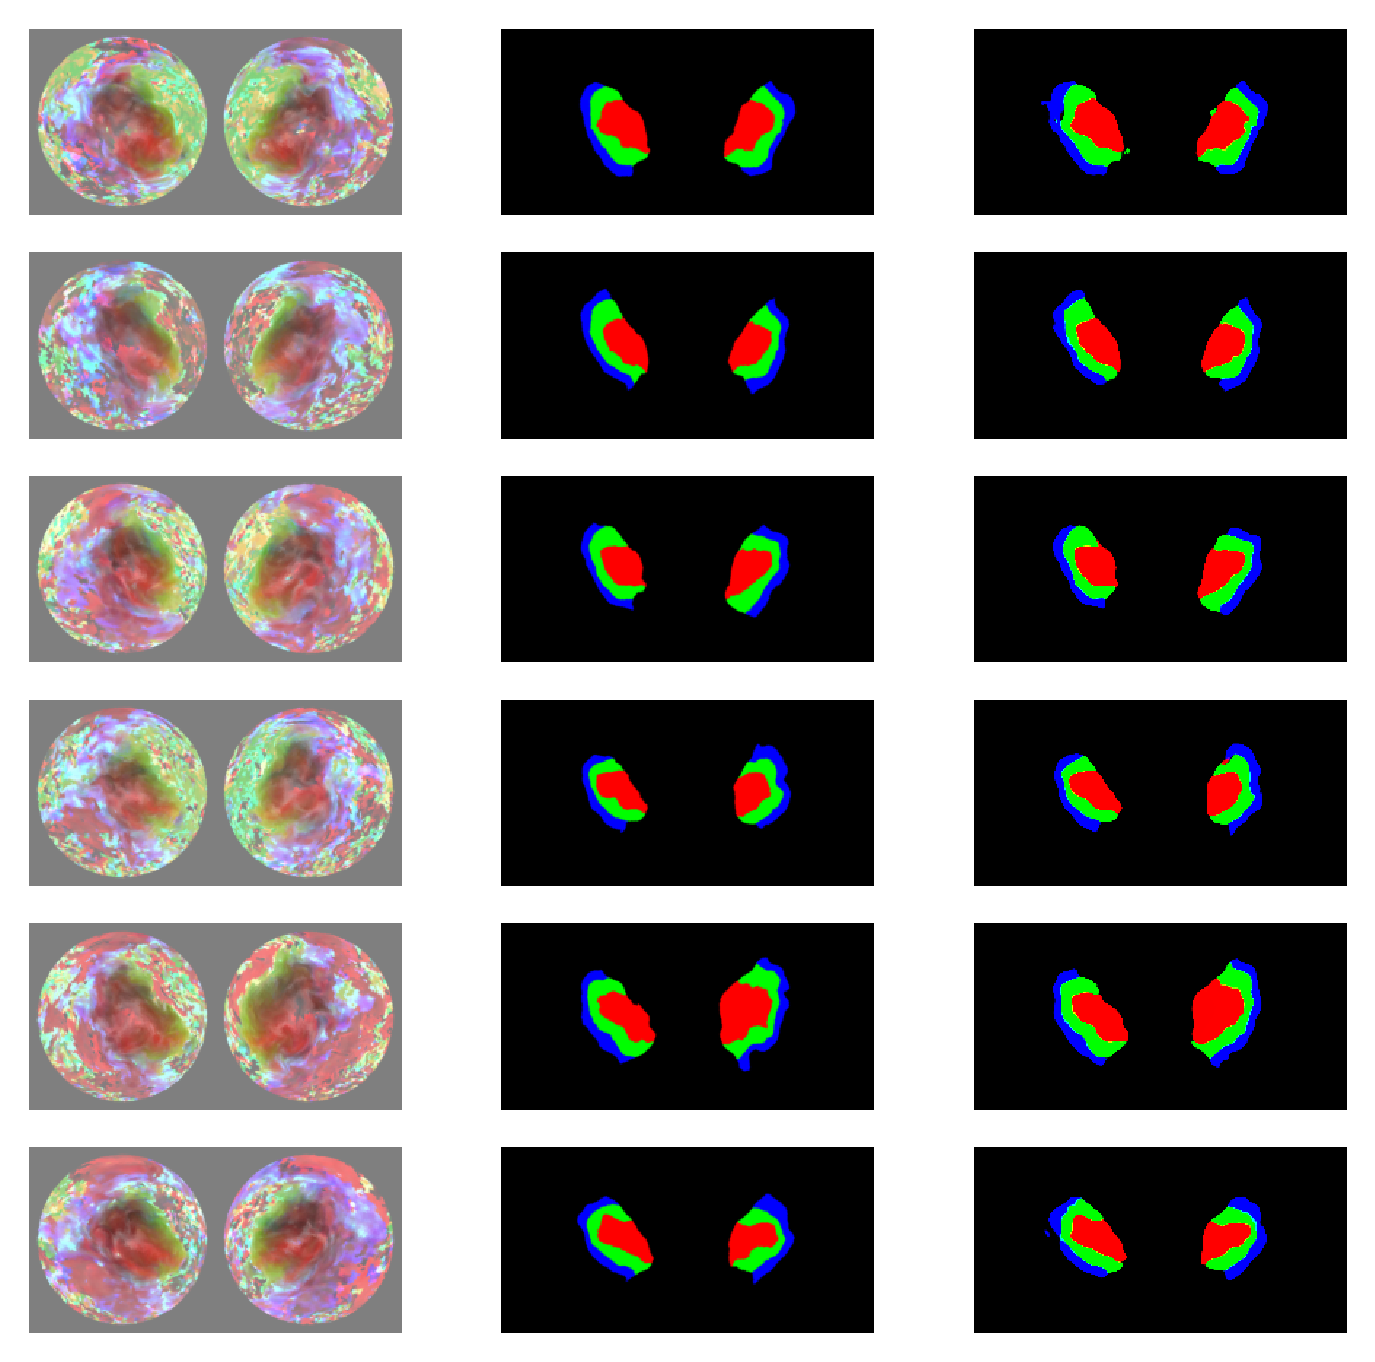

In [46]:
plot_idcs = np.arange(6)

(fig,axs) = plt.subplots(len(plot_idcs), 3, figsize=(6, len(plot_idcs)), dpi=72*4)

for (axrow,idx) in zip(axs, plot_idcs):
    plot_prediction(datasets['val'][dataset], idx, trained_model, axes=axrow)

pass

In [47]:
dataset = 'anat'
pretrained = False

# We are using a batch size of 1 and want to reduce the learning rate
# only after we have been through each data-point once.
ntrn = len(datasets['trn'][dataset])
cpath = os.path.join(resnet_path, dataset)
# The plan for our training:
base_opts = {'batch_size': 1, 'step_size': ntrn, 'dataset':dataset}
training_plan = [
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=False, bce_weight=0.67),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.33),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.00)
]

initial_model = resnet_model(pretrained=pretrained)
(trained_model, loss, dice) = plan_to_model(initial_model, training_plan,
                                            cache_path=cpath)

epoch    lr     dt[s]   trn bce   trn dice  trn loss   val bce   val dice  val loss
=====--=======--=====-+-========--========--========-+-========--========--========
 1/10  0.00375   14.7 |    0.940     0.757     0.879 |    0.056     0.483     0.196 *
 2/10  0.00337   21.1 |    0.047     0.414     0.168 |    0.040     0.375     0.151 *
 3/10  0.00304   18.8 |    0.038     0.343     0.138 |    0.038     0.330     0.134 *
 4/10  0.00273   16.4 |    0.034     0.312     0.126 |    0.046     0.319     0.136 
 5/10  0.00246   15.7 |    0.031     0.290     0.117 |    0.043     0.322     0.135 
 6/10  0.00221   15.4 |    0.030     0.276     0.111 |    0.034     0.291     0.119 *
 7/10  0.00199   15.2 |    0.028     0.262     0.105 |    0.034     0.293     0.119 
 8/10  0.00179   14.7 |    0.026     0.251     0.100 |    0.034     0.303     0.123 
 9/10  0.00161   14.6 |    0.025     0.243     0.097 |    0.035     0.301     0.123 
10/10  0.00145   14.2 |    0.024     0.234     0.093 |    0.035

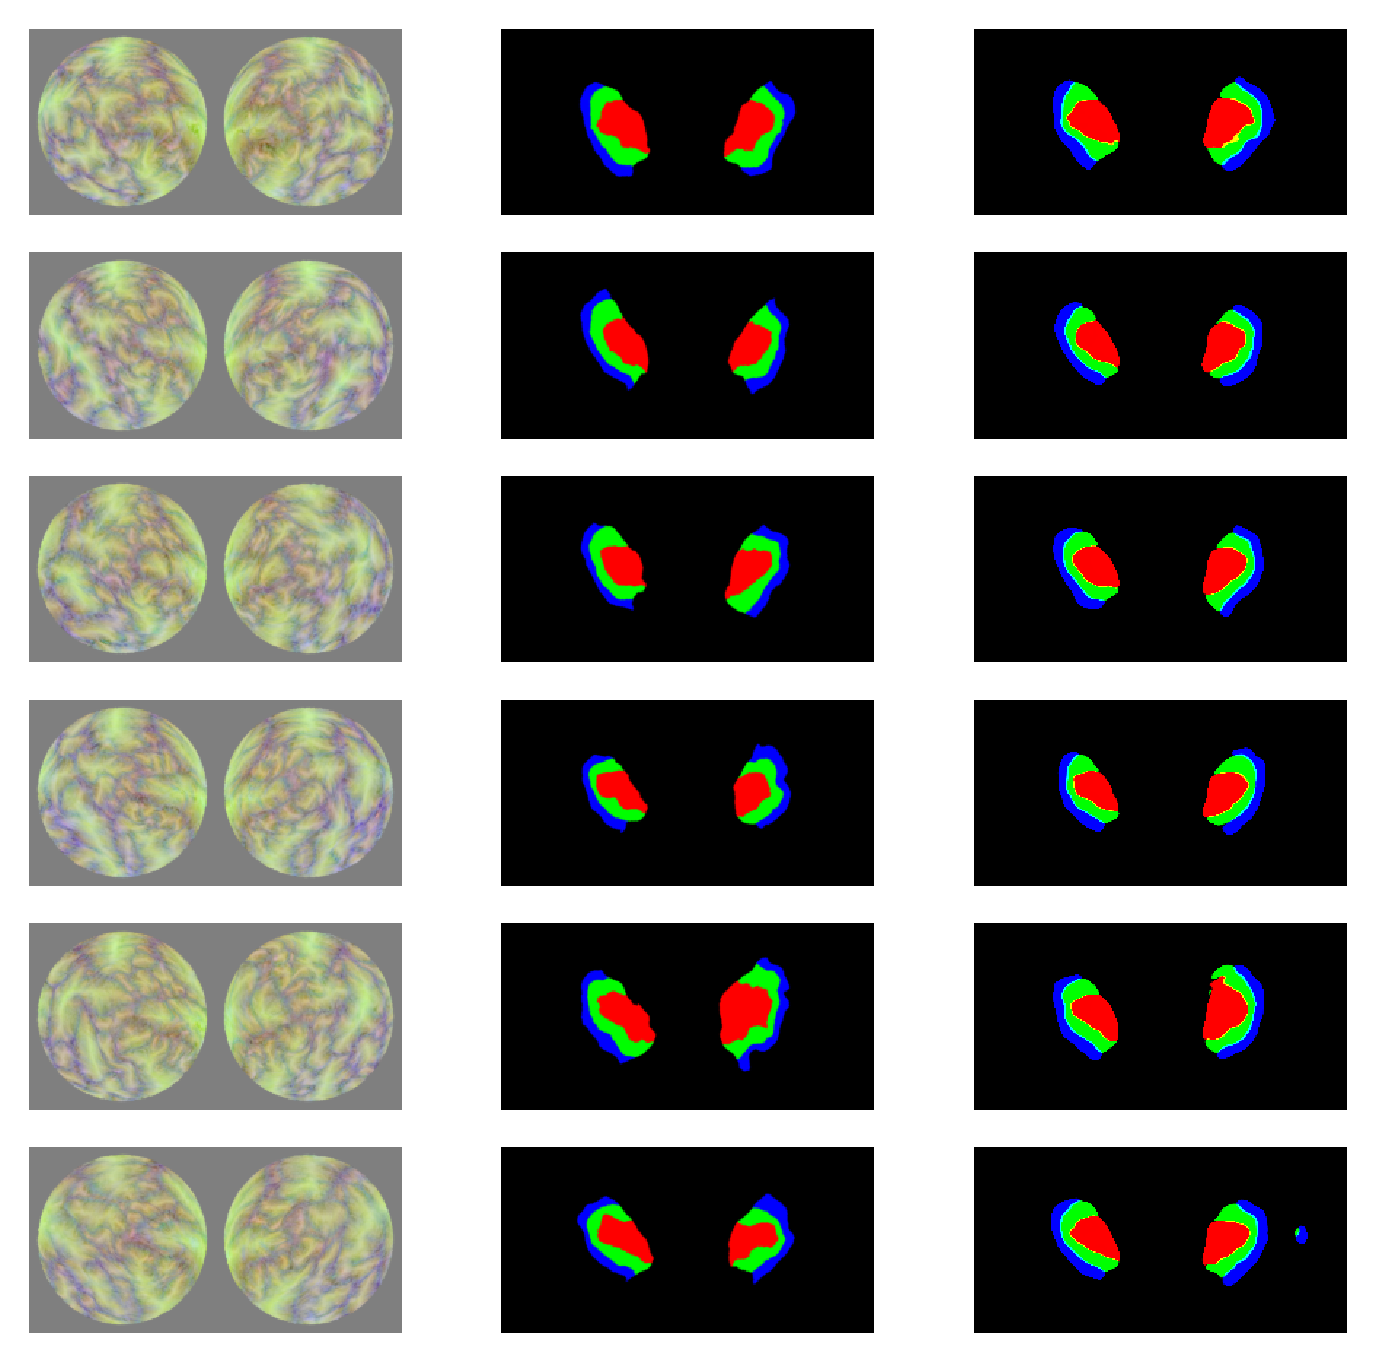

In [48]:
# Example subjects (the validation subject IDs are randomly chosen every time
# this notebook is run, so just pick a number of them).
plot_idcs = np.arange(6)

(fig,axs) = plt.subplots(len(plot_idcs), 3, figsize=(6, len(plot_idcs)), dpi=72*4)

for (axrow,idx) in zip(axs, plot_idcs):
    plot_prediction(datasets['val'][dataset], idx, trained_model, axes=axrow)

pass

### Hyper-parameter Grid Search

In [17]:
grid_params = {
    'dataset': ['func','anat'],
    'batch_size': [1],
    'step_size': [len(datasets['trn']['func'])],
    'lr': [0.025,0.0125,0.008,0.005,0.00375,0.0025,0.00125],
    'gamma': [0.95, 0.9, 0.75, 0.5, 0.25],
    'pretrained': [True, False]}

grid = []
for (k,vs) in grid_params.items():
    if len(grid) == 0:
        grid = [{k:v} for v in vs]
    else:
        grid = [dict(u, **{k:v}) for u in grid for v in vs]

In [ ]:
import shutil

os.nice(10) # run these nicely!
cpath0 = os.path.join(resnet_path, 'grid')

for (ii,row) in enumerate(grid):
    if ii % 12 == 0:
        print("%3d of %-3d (%6.2f%%)" % (ii+1, len(grid), ii/(len(grid)-1)*100))
    tag = 'dat%04d' % (ii,)
    cpath = os.path.join(cpath0, tag)
    cfile = os.path.join(cpath0, tag + '.json')
    if os.path.isfile(cfile):
        for (k,v) in ny.load(cfile).items():
            row[k] = v
        continue
    mdl0 = resnet_model(pretrained=row['pretrained'])
    (mdl,loss,dice) = plan_to_model(mdl0, [row], cache_path=cpath, logger=None)
    row['tag'] = tag
    row['loss'] = loss
    row['dice'] = dice
    # Clear out the files that we don't need and resave the model and data
    ny.save(cfile, row)
    shutil.move(os.path.join(cpath,  'round01', 'optim000019.pkl'),
                os.path.join(cpath0, 'opt%04d.pkl' % ii))
    shutil.move(os.path.join(cpath,  'round01', 'model000019.pkl'),
                os.path.join(cpath0, 'mdl%04d.pkl' % ii))
    shutil.rmtree(cpath)    
    
grid = ny.to_dataframe(grid)